In [1]:
import numpy as np
import arms
import matplotlib.pyplot as plt

__Bernoulli Multi-Arm Bandit definition__

In [110]:
K = 6  # nr of arms
SEED = 17  #  seed for reproducibility
T = 5000
np.random.seed(SEED)

bernoulli_param = [np.random.rand() for i in range(K)]
random_seed = [np.random.randint(1, 312414) for i in range(K)]

bernoulli_MAB = [arms.ArmBernoulli(p=p, random_state=seed) for (p, seed) in zip(bernoulli_param, random_seed)]

## Upper Confidence Bound

In [119]:
def UCB1(T, MAB, rho):
    def init_UCB1(T, MAB):
        # get number of arms
        K = len(MAB)
    
        # initialize loop variables at t=0
        draws = np.zeros((K, T))  
        reward = np.zeros((K, T))
    
        # initialize empirical mean
        for i, arm in enumerate(MAB):
            arm_draw = arm.sample()
            reward[i, i] += arm_draw
            draws[i, i] = 1
        empiric_mean = np.sum(reward[:, :K], axis=1)  # no need to divide by nr_draws as = 1
        
        return K, draws, reward, empiric_mean
    
    def upper_confidence_bound(t, rho, empiric_mean, draws):
        cum_draws = np.sum(draws[:, :t], axis=1)
        foo = rho * np.sqrt(np.log(t) / (2 * cum_draws))
        foo = empiric_mean + foo
        return foo
    
    def iterate(t, rho, MAB, draws, reward, empiric_mean):
        # Compute list of upper confidence bound values
        upper_confidence_bounds = upper_confidence_bound(t, rho, empiric_mean, draws)
        
        # Select maximizing arm
        arm_idx = np.argmax(upper_confidence_bounds)
        
        # Draw chosen arm
        arm_draw = MAB[arm_idx].sample()
        
        # Update records
        draws[arm_idx, t+1] = 1
        reward[arm_idx, t+1] = arm_draw
        cum_reward_arm = np.sum(reward[arm_idx, :t+1], axis=0)
        cum_draws_arm = np.sum(draws[arm_idx, :t+1], axis=0)
        empiric_mean[arm_idx] = cum_reward_arm / cum_draws_arm
        
        return draws, reward, empiric_mean
    
    # Initialize Bandit
    K, draws, reward, empiric_mean = init_UCB1(T, MAB)
    
    # Iterate
    for t in range(K, T-1):
        draws, reward, empiric_mean = iterate(t, rho, MAB, draws, reward, empiric_mean)
    
    # Define output sequences
    rew_sequence = np.sum(reward, axis=0)
    draws_sequence = np.argmax(draws, axis=0)
    
    return rew_sequence, draws_sequence

In [120]:
rew_UCB1, draws_USB1 = UCB1(T, bernoulli_MAB, rho=.2)

## Thompson Sampling

In [113]:
from scipy.special import beta

In [121]:
def TS(T, MAB):
    def init_TS(T, MAB):
        # get number of arms
        K = len(MAB)
    
        # initialize loop variables at t=0
        draws = np.zeros((K, T))  
        reward = np.zeros((K, T))
    
        return draws, reward
    
    def iterate(t, MAB, draws, rewards):
        # Setup beta function evaluation params set
        cum_reward_t = np.sum(reward[:, :t], axis=1)
        cum_draws_t = np.sum(draws[:, :t], axis=1)
        a_param = cum_reward_t + 1
        b_param = cum_draws_t - cum_reward_t + 1
    
        # Compute posteriors
        posteriors = [beta(a, b) for a, b in zip(a_param, b_param)]
    
        # Select maximizing arm
        arm_idx = np.argmax(posteriors)
    
        # Draw chosen arm
        arm_draw = MAB[arm_idx].sample()
    
        # Update records
        draws[arm_idx, t+1] = 1
        reward[arm_idx, t+1] = arm_draw
    
        return draws, reward
    
    # Initialize Bandit
    draws, reward = init_TS(T, MAB)
    
    # Iterate
    for t in range(T-1):
        draws, reward = iterate(t, MAB, draws, reward)
        
    # Define output sequences
    rew_sequence = np.sum(reward, axis=0)
    draws_sequence = np.argmax(draws, axis=0)
    
    return rew_sequence, draws_sequence     

In [122]:
rew_TS, draws_TS = TS(T, bernoulli_MAB)

## Naive Sampling

In [123]:
def Naive(T, MAB):
    def init_naive(T, MAB):
        # get number of arms
        K = len(MAB)
    
        # initialize loop variables at t=0
        draws = np.zeros((K, T))  
        reward = np.zeros((K, T))
    
        return draws, reward
    
    def iterate(t, MAB, draws, reward):
        # Compute empirical mean
        cum_reward_t = np.sum(reward[:, :t], axis=1)
        cum_draws_t = np.sum(draws[:, :t], axis=1)
        empirical_mean = cum_reward_t / cum_draws_t
    
        # Select maximizing arm
        arm_idx = np.argmax(empirical_mean)
    
        # Draw chosen arm
        arm_draw = MAB[arm_idx].sample()
    
        # Update records
        draws[arm_idx, t+1] = 1
        reward[arm_idx, t+1] = arm_draw
    
        return draws, reward
    
    # Initialize Bandit
    draws, reward = init_naive(T, MAB)
    
    # Iterate
    for t in range(T-1):
        draws, reward = iterate(t, MAB, draws, reward)
        
    # Define output sequences
    rew_sequence = np.sum(reward, axis=0)
    draws_sequence = np.argmax(draws, axis=0)
    
    return rew_sequence, draws_sequence     

In [124]:
rew_naive, draws_naive = Naive(T, bernoulli_MAB)

/Users/dieze/anaconda/envs/rl_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


### Regret Curves

In [125]:
def regret_bernoulli(t, MAB, rew):
    # Get mean of best bernoulli arm
    means = [arm.mean for arm in MAB]
    mean_max = np.max(means)
    
    # compute regret array
    reg = mean_max * np.arange(1, t + 1) - np.cumsum(rew)
    return reg

In [127]:
reg_UCB1 = regret_bernoulli(T, bernoulli_MAB, rew_UCB1)
reg_TS = regret_bernoulli(T, bernoulli_MAB, rew_TS)
reg_naive = regret_bernoulli(T, bernoulli_MAB, rew_naive)

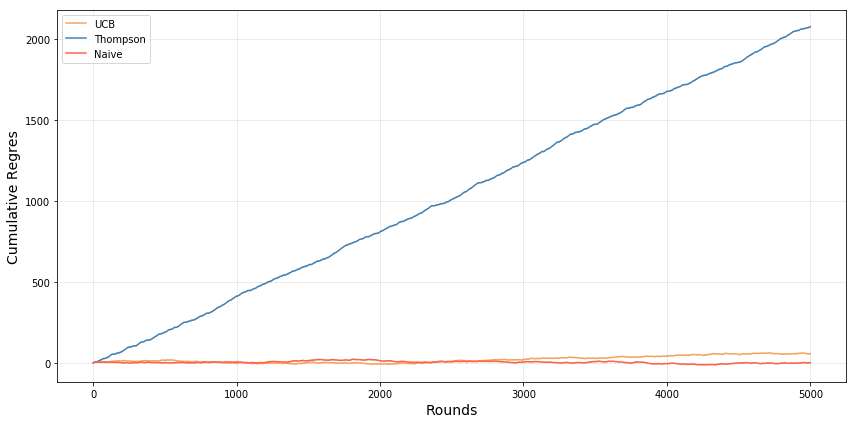

In [128]:
fig, ax = plt.subplots(figsize=(12,6))

x = np.arange(1, T+1)
ax.plot(x, reg_UCB1, label="UCB", color="sandybrown")
ax.plot(x, reg_TS, label="Thompson", color="steelblue")
ax.plot(x, reg_naive, label="Naive", color="tomato")
ax.grid(alpha=0.3)
ax.set_xlabel("Rounds", size=14)
ax.set_ylabel("Cumulative Regres", size=14)

plt.legend()
plt.tight_layout()
plt.show()